Всем привет! Сегодня вы впервые попробуете написать свою собственную нейронную сеть и попробовать ее обучить. Мы будем работать с картинками, но пока что не совсем тем способом, которым лучше всего это делать, но должно получиться неплохо.

Будем работать с [датасетом](https://github.com/rois-codh/kmnist) `Kuzushiji-MNIST` (`KMNIST`). Это рукописные буквы, изображения имеют размер (28, 28, 1) и разделены на 10 классов, по ссылке можно прочитать подробнее.

In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from IPython.display import clear_output

## Загрузка данных

Сейчас мы будем использовать встроенные данные, но в реальности приходится писать свой класс для датасета (Dataset), у которого реализовывать несколько обязательных методов (напр, `__getitem__`), но это обсудим уже потом.

In [2]:
import torchvision
from torchvision.datasets import KMNIST


# Превращает картинки в тензоры
transform = torchvision.transforms.Compose(
    [torchvision.transforms.ToTensor()])

# Загрузим данные (в переменных лежат объекты типа `Dataset`)
# В аргумент `transform` мы передаем необходимые трансформации (ToTensor)
trainset = KMNIST(root="./KMNIST", train=True, download=True, transform=transform)
testset = KMNIST(root="./KMNIST", train=False, download=True, transform=transform)

clear_output()

Определим даталоадеры, они нужны, чтобы реализовывать стохастический градиентный спуск (то есть мы не хотим считывать в оперативную память все картинки сразу, а делать это батчами).

In [3]:
from torch.utils.data import DataLoader


# Можно оставить таким
batch_size = 256

trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

Подумайте, как может влиять на скорость обучения параметр `batch_size`, почему вы так считаете?

**Ответ:** чем больше `batch_size`, тем быстрее скорость обучения. Проще пропустить маленькую часть датасета через нейронную сеть, чем весь дадасет целиком.


Посмотрим на какую-нибудь картинку:

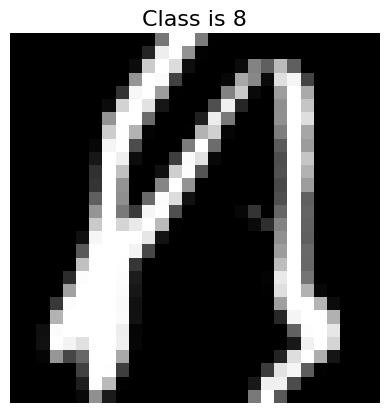

In [4]:
plt.imshow(trainset[0][0].view(28, 28).numpy(), cmap="gray")
plt.axis("off")
plt.title(f"Class is {trainset[0][1]}", fontsize=16);

### Задание 1. Смотрим на картинки

**2** балла

Нарисуйте на одном графике изображения всех 10 классов:

⣿⣿⣿⣿⣿⣿⠿⢋⣥⣴⣶⣶⣶⣬⣙⠻⠟⣋⣭⣭⣭⣭⡙⠻⣿⣿⣿⣿⣿
⣿⣿⣿⣿⡿⢋⣴⣿⣿⠿⢟⣛⣛⣛⠿⢷⡹⣿⣿⣿⣿⣿⣿⣆⠹⣿⣿⣿⣿
⣿⣿⣿⡿⢁⣾⣿⣿⣴⣿⣿⣿⣿⠿⠿⠷⠥⠱⣶⣶⣶⣶⡶⠮⠤⣌⡙⢿⣿
⣿⡿⢛⡁⣾⣿⣿⣿⡿⢟⡫⢕⣪⡭⠥⢭⣭⣉⡂⣉⡒⣤⡭⡉⠩⣥⣰⠂⠹
⡟⢠⣿⣱⣿⣿⣿⣏⣛⢲⣾⣿⠃⠄⠐⠈⣿⣿⣿⣿⣿⣿⠄⠁⠃⢸⣿⣿⡧
⢠⣿⣿⣿⣿⣿⣿⣿⣿⣇⣊⠙⠳⠤⠤⠾⣟⠛⠍⣹⣛⣛⣢⣀⣠⣛⡯⢉⣰
⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣷⡶⠶⢒⣠⣼⣿⣿⣛⠻⠛⢛⣛⠉⣴⣿⣿
⣿⣿⣿⣿⣿⣿⣿⡿⢛⡛⢿⣿⣿⣶⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣷⡈⢿⣿
⣿⣿⣿⣿⣿⣿⣿⠸⣿⡻⢷⣍⣛⠻⠿⠿⣿⣿⣿⣿⣿⣿⣿⣿⣿⠿⢇⡘⣿
⣿⣿⣿⣿⣿⣿⣿⣷⣝⠻⠶⣬⣍⣛⣛⠓⠶⠶⠶⠤⠬⠭⠤⠶⠶⠞⠛⣡⣿
⢿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣷⣶⣬⣭⣍⣙⣛⣛⣛⠛⠛⠛⠿⠿⠿⠛⣠⣿⣿
⣦⣈⠉⢛⠻⠿⠿⢿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⡿⠿⠛⣁⣴⣾⣿⣿⣿⣿
⣿⣿⣿⣶⣮⣭⣁⣒⣒⣒⠂⠠⠬⠭⠭⠭⢀⣀⣠⣄⡘⠿⣿⣿⣿⣿⣿⣿⣿
⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣦⡈⢿⣿⣿⣿⣿⣿





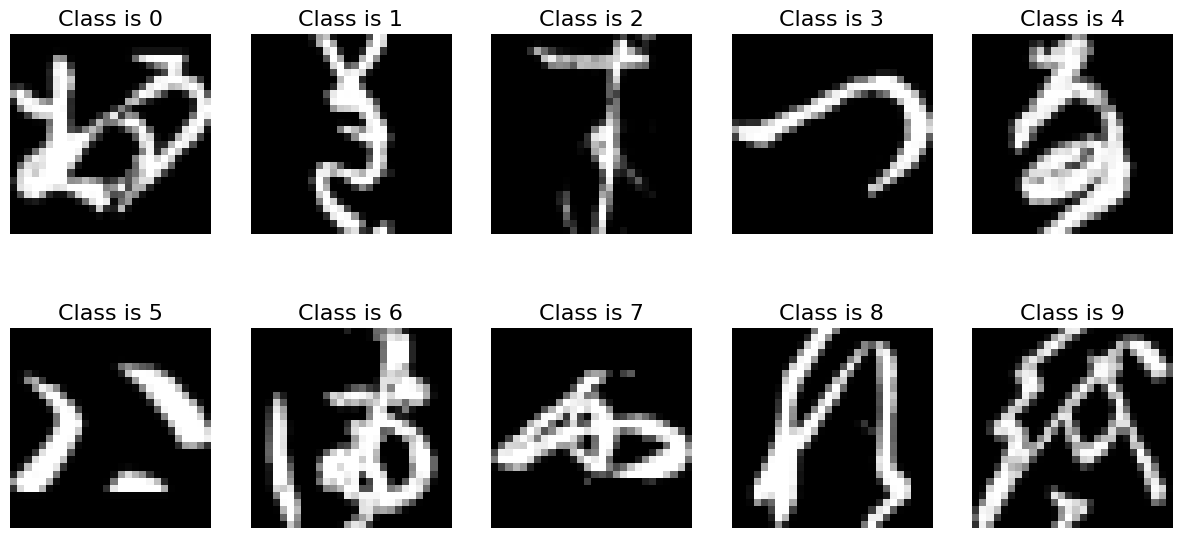

In [9]:
fig = plt.figure(figsize=(15,7))
c = 1
for clas in range(10):
  for i in range(len(trainset)):
    if trainset[i][1] == clas:
      plt.subplot(2, 5, c)
      plt.imshow(trainset[i][0].view(28, 28).numpy(), cmap="gray")
      plt.axis("off")
      plt.title(f"Class is {trainset[i][1]}", fontsize=16);
      c = c + 1
      break



### Задание 2. Строим свой первый MLP

**4** балла

MLP (multilayer perceptron) или нейронная сеть из полносвязных (линейных) слоев, это мы уже знаем.

Опишите структуру сети: 3 полносвязных слоя + функции активации на ваш выбор. **Подумайте** про активацию после последнего слоя!

Сеть на выходе 1 слоя должна иметь 256 признаков, на выходе из 2 128 признаков, на выходе из последнего столько, сколько у вас классов.
 
https://pytorch.org/docs/stable/nn.html?highlight=activation#non-linear-activations-weighted-sum-nonlinearity

In [10]:
import torch.nn as nn

class FCNet(nn.Module):
    def __init__(self):
        super().__init__() #  это надо помнить!
        ## YOUR CODE HERE

        # Опрелелим три слоя
        # fc - fully connected (по сути значит линейные слои)

        # in_features число входов у каждого нейрона, out_features число нейронов
        self.fc1 = nn.Linear(in_features=28*28, out_features=256)
        # in_features число входов у каждого нейрона, out_features число нейронов
        self.fc2 = nn.Linear(in_features=256, out_features=128)
        # in_features число нейронов пред слоя, out_features число классов (10)
        self.fc3 = nn.Linear(in_features=128, out_features=10)

        self.activation = nn.ReLU() # можно так, а можно уже в forward'е
        

    def forward(self, x):  # Forward вызывается внутри метода __call__ родительского класса
        ## x -> тензор размерности (BATCH_SIZE, N_CHANNELS, WIDTH, HEIGHT)
        ## надо подумать над тем, что у нас полносвязные слои принимают векторы

        ## YOUR CODE HERE

        x = x.view(-1, 28*28) # переведем картинку в вектор
        x = self.fc1(x)
        x = self.activation(x)
        x = self.fc2(x)
        x = self.activation(x)
        x = self.fc3(x)

        return x

Сколько обучаемых параметров у вашей модели (весов и смещений)?

**Ответ:**

**Веса:** 784 * 256 + 256 * 128 + 128 * 10 = 234752

Смещения – это веса, добавленные к скрытым слоям.

**Смещения:** 256 + 128 + 10 = 394


### Задание 3. Напишите код для обучения модели

**5** баллов

Можно (и нужно) подглядывать в код семинара по пайторчу. Вам нужно создать модель, определить функцию потерь и оптимизатор (начнем с `SGD`). Дальше нужно обучать модель, при помощи тренировочного `Dataloader'a` и считать лосс на тренировочном и тестовом `Dataloader'ах`.

Напишем функцию для рассчета `accuracy`:

In [36]:
def get_accuracy(model, dataloader):
    """
    model - обученная нейронная сеть
    dataloader - даталоадер, на котором вы хотите посчитать accuracy
    """
    correct = 0
    total = 0
    with torch.no_grad(): # Тензоры внутри этого блока будут иметь requires_grad=False
        for images, labels in dataloader:
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = correct / total
    
    return accuracy

#### Основной цикл обучения

Этот код можно (и зачастую нужно) выносить в отдельную функцию, но пока что можете это не делать, все по желанию)

In [37]:
# Создадим объект модели
fc_net = FCNet()
# Определим функцию потерь
loss_function = nn.CrossEntropyLoss()
# Создадим оптимизатор для нашей сети
lr = 0.001 # скорость обучения
optimizer = torch.optim.Adam(fc_net.parameters(), lr=3e-4)

Напишите цикл обучения. Для начала хватит 10 эпох. Какое значение `accuracy` на тестовой выборке удалось получить?

In [38]:
n_epochs = 20
loss_history = []

## YOUR CODE HERE

for epoch in range(n_epochs):
    epoch_loss = 0
    for images, labels in trainloader: # Получаем батч тренировочных картинок
        optimizer.zero_grad() # чтобы не было как в лог регрессии, когда мы не обнуляли градиенты
        outputs = fc_net(images) # делаем предсказания
        loss = loss_function(outputs, labels) # считаем лосс
        loss.backward() # считаем градиенты
        optimizer.step() # делаем шаг градиентного спуска

        epoch_loss += loss.item()

    loss_history.append(epoch_loss/len(trainloader))

    print(f"Epoch={epoch+1} loss={loss_history[epoch]:.4f}")


Epoch=1 loss=0.6874
Epoch=2 loss=0.3033
Epoch=3 loss=0.2248
Epoch=4 loss=0.1767
Epoch=5 loss=0.1425
Epoch=6 loss=0.1143
Epoch=7 loss=0.0944
Epoch=8 loss=0.0769
Epoch=9 loss=0.0626
Epoch=10 loss=0.0510
Epoch=11 loss=0.0418
Epoch=12 loss=0.0332
Epoch=13 loss=0.0271
Epoch=14 loss=0.0212
Epoch=15 loss=0.0165
Epoch=16 loss=0.0129
Epoch=17 loss=0.0110
Epoch=18 loss=0.0078
Epoch=19 loss=0.0057
Epoch=20 loss=0.0052


In [15]:
print(f"Accuracy on testloader for 10 epochs = {get_accuracy(fc_net, testloader)}")

Accuracy on testloader for 10 epochs = 0.8789


In [40]:
print(f"Accuracy on testloader for 20 epochs = {get_accuracy(fc_net, testloader)}")

Accuracy on testloader for 20 epochs = 0.9057


In [41]:
n_epochs = 30
loss_history = []

## YOUR CODE HERE

for epoch in range(n_epochs):
    epoch_loss = 0
    for images, labels in trainloader: # Получаем батч тренировочных картинок
        optimizer.zero_grad() # чтобы не было как в лог регрессии, когда мы не обнуляли градиенты
        outputs = fc_net(images) # делаем предсказания
        loss = loss_function(outputs, labels) # считаем лосс
        loss.backward() # считаем градиенты
        optimizer.step() # делаем шаг градиентного спуска

        epoch_loss += loss.item()

    loss_history.append(epoch_loss/len(trainloader))

    print(f"Epoch={epoch+1} loss={loss_history[epoch]:.4f}")

Epoch=1 loss=0.0037
Epoch=2 loss=0.0025
Epoch=3 loss=0.0022
Epoch=4 loss=0.0018
Epoch=5 loss=0.0015
Epoch=6 loss=0.0011
Epoch=7 loss=0.0009
Epoch=8 loss=0.0008
Epoch=9 loss=0.0006
Epoch=10 loss=0.0005
Epoch=11 loss=0.0005
Epoch=12 loss=0.0005
Epoch=13 loss=0.0004
Epoch=14 loss=0.0003
Epoch=15 loss=0.0003
Epoch=16 loss=0.0002
Epoch=17 loss=0.0002
Epoch=18 loss=0.0002
Epoch=19 loss=0.0001
Epoch=20 loss=0.0001
Epoch=21 loss=0.0001
Epoch=22 loss=0.0001
Epoch=23 loss=0.0001
Epoch=24 loss=0.0001
Epoch=25 loss=0.0001
Epoch=26 loss=0.0001
Epoch=27 loss=0.0000
Epoch=28 loss=0.0000
Epoch=29 loss=0.0000
Epoch=30 loss=0.0000


In [42]:
print(f"Accuracy on testloader for 30 epochs = {get_accuracy(fc_net, testloader)}")

Accuracy on testloader for 30 epochs = 0.9062


### Задание 4. Изучение влияния нормализации

**3** балла

Вы могли заметить, что мы забыли провести нормализацию наших данных, а для нейронных сетей это может быть очень критично.

Нормализуйте данные.

* Подсчитайте среднее значение и стандартное отклонение интенсивности пикселей для всех тренировочных данных
* Нормализуйте данные с использованием этих параметров (используйте трансформацию `Normalize`)


Оцените влияние нормировки данных.

In [43]:
next(iter(trainloader))[0].shape

torch.Size([256, 1, 28, 28])

In [45]:
mean = torch.mean(next(iter(trainloader))[0]) ## calculate mean
std = torch.std(next(iter(trainloader))[0])## calculate std
print(mean, std)

transform_with_norm = torchvision.transforms.Compose([
                torchvision.transforms.ToTensor(),
                torchvision.transforms.Normalize(mean, std)
            ])

trainset.transform = transform_with_norm 
testset.transform = transform_with_norm

tensor(0.1942) tensor(0.3440)


In [46]:
fc_net = FCNet()
loss_function = nn.CrossEntropyLoss()
lr = 0.001
optimizer = torch.optim.Adam(fc_net.parameters(), lr=3e-4)

In [47]:
n_epochs = 10
loss_history = []

## YOUR CODE HERE

for epoch in range(n_epochs):
    epoch_loss = 0
    for images, labels in trainloader: # Получаем батч тренировочных картинок
        optimizer.zero_grad() # чтобы не было как в лог регрессии, когда мы не обнуляли градиенты
        outputs = fc_net(images) # делаем предсказания
        loss = loss_function(outputs, labels) # считаем лосс
        loss.backward() # считаем градиенты
        optimizer.step() # делаем шаг градиентного спуска

        epoch_loss += loss.item()

    loss_history.append(epoch_loss/len(trainloader))

    print(f"Epoch={epoch+1} loss={loss_history[epoch]:.4f}")

Epoch=1 loss=0.6741
Epoch=2 loss=0.2997
Epoch=3 loss=0.2200
Epoch=4 loss=0.1725
Epoch=5 loss=0.1375
Epoch=6 loss=0.1113
Epoch=7 loss=0.0915
Epoch=8 loss=0.0757
Epoch=9 loss=0.0611
Epoch=10 loss=0.0495


In [48]:
print(f"Accuracy on testloader for 10 epochs = {get_accuracy(fc_net, testloader)}")

Accuracy on testloader for 10 epochs = 0.9007


In [49]:
n_epochs = 30
loss_history = []

## YOUR CODE HERE

for epoch in range(n_epochs):
    epoch_loss = 0
    for images, labels in trainloader: # Получаем батч тренировочных картинок
        optimizer.zero_grad() # чтобы не было как в лог регрессии, когда мы не обнуляли градиенты
        outputs = fc_net(images) # делаем предсказания
        loss = loss_function(outputs, labels) # считаем лосс
        loss.backward() # считаем градиенты
        optimizer.step() # делаем шаг градиентного спуска

        epoch_loss += loss.item()

    loss_history.append(epoch_loss/len(trainloader))

    print(f"Epoch={epoch+1} loss={loss_history[epoch]:.4f}")


Epoch=1 loss=0.0404
Epoch=2 loss=0.0317
Epoch=3 loss=0.0248
Epoch=4 loss=0.0203
Epoch=5 loss=0.0152
Epoch=6 loss=0.0116
Epoch=7 loss=0.0102
Epoch=8 loss=0.0072
Epoch=9 loss=0.0059
Epoch=10 loss=0.0043
Epoch=11 loss=0.0033
Epoch=12 loss=0.0025
Epoch=13 loss=0.0020
Epoch=14 loss=0.0016
Epoch=15 loss=0.0013
Epoch=16 loss=0.0010
Epoch=17 loss=0.0009
Epoch=18 loss=0.0007
Epoch=19 loss=0.0006
Epoch=20 loss=0.0005
Epoch=21 loss=0.0005
Epoch=22 loss=0.0004
Epoch=23 loss=0.0003
Epoch=24 loss=0.0003
Epoch=25 loss=0.0002
Epoch=26 loss=0.0002
Epoch=27 loss=0.0002
Epoch=28 loss=0.0002
Epoch=29 loss=0.0001
Epoch=30 loss=0.0001


In [50]:
print(f"Accuracy on testloader for 30 epochs = {get_accuracy(fc_net, testloader)}")

Accuracy on testloader for 30 epochs = 0.9059


Как изменилась `accuracy` после нормализации?

`accurancy` увеличилась при 10 эпохах, но особо не изменилась при 30 эпохах

### Задание 5. Изучение влияния функции активации

**3** балла

Исследуйте влияние функций активации на скорость обучения и точность предсказаний модели.

Используйте три функции:

* [Sigmoid](https://pytorch.org/docs/stable/nn.functional.html#sigmoid)
* [GELU](https://pytorch.org/docs/stable/nn.functional.html#gelu)
* [Tanh](https://pytorch.org/docs/stable/generated/torch.nn.Tanh.html#torch.nn.Tanh)

In [52]:
## YOUR CODE HERE
class FCNet(nn.Module):
    def __init__(self, activation_func = nn.ReLU()):
        super().__init__() #  это надо помнить!
        ## YOUR CODE HERE

        # Опрелелим три слоя
        # in_features число входов у каждого нейрона, out_features число нейронов
        self.fc1 = nn.Linear(in_features=28*28, out_features=256)
        self.fc2 = nn.Linear(in_features=256, out_features=128)
        self.fc3 = nn.Linear(in_features=128, out_features=10)

        self.activation = activation_func
        
    def forward(self, x):  
        x = x.view(-1, 28*28) # переведем картинку в вектор
        x = self.fc1(x)
        x = self.activation(x)
        x = self.fc2(x)
        x = self.activation(x)
        x = self.fc3(x)

        return x

In [59]:
activation_function = [nn.Sigmoid(), nn.GELU(), nn.Tanh()]
for func in activation_function:
  fc_net = FCNet(activation_func = func)
  loss_function = nn.CrossEntropyLoss()
  lr = 0.001 # скорость обучения
  optimizer = torch.optim.Adam(fc_net.parameters(), lr=3e-4)
  
  n_epochs = 10
  loss_history = []
  for epoch in range(n_epochs):
    epoch_loss = 0
    for images, labels in trainloader: # Получаем батч тренировочных картинок
        optimizer.zero_grad() # чтобы не было как в лог регрессии, когда мы не обнуляли градиенты
        outputs = fc_net(images) # делаем предсказания
        loss = loss_function(outputs, labels) # считаем лосс
        loss.backward() # считаем градиенты
        optimizer.step() # делаем шаг градиентного спуска

        epoch_loss += loss.item()
    loss_history.append(epoch_loss/len(trainloader))
    print(f"Epoch={epoch+1} loss={loss_history[epoch]:.4f}")
  
  print(f"Accuracy, activation function - {func} = {get_accuracy(fc_net, testloader)}")

Epoch=1 loss=1.5460
Epoch=2 loss=0.7457
Epoch=3 loss=0.5409
Epoch=4 loss=0.4392
Epoch=5 loss=0.3689
Epoch=6 loss=0.3155
Epoch=7 loss=0.2728
Epoch=8 loss=0.2374
Epoch=9 loss=0.2089
Epoch=10 loss=0.1842
Accuracy, activation function - Sigmoid() = 0.8521
Epoch=1 loss=0.6588
Epoch=2 loss=0.2815
Epoch=3 loss=0.2032
Epoch=4 loss=0.1546
Epoch=5 loss=0.1203
Epoch=6 loss=0.0954
Epoch=7 loss=0.0767
Epoch=8 loss=0.0620
Epoch=9 loss=0.0484
Epoch=10 loss=0.0372
Accuracy, activation function - GELU(approximate='none') = 0.9014
Epoch=1 loss=0.7798
Epoch=2 loss=0.3822
Epoch=3 loss=0.2582
Epoch=4 loss=0.1861
Epoch=5 loss=0.1377
Epoch=6 loss=0.1038
Epoch=7 loss=0.0781
Epoch=8 loss=0.0587
Epoch=9 loss=0.0436
Epoch=10 loss=0.0319
Accuracy, activation function - Tanh() = 0.8929


С использованием какой функции активации удалось досчить наибольшей `accuracy`?

Наибольший accuracy при использовании функции **GELU**

### Задание 6. Другие оптимизаторы

**4** балла

Исследуйте влияние оптимизаторов на скорость обучения и точность предсказаний модели.

Попробуйте следующие:

* [Adam](https://pytorch.org/docs/stable/generated/torch.optim.Adam.html#torch.optim.Adam)
* [RMSprop](https://pytorch.org/docs/stable/generated/torch.optim.RMSprop.html#torch.optim.RMSprop)
* [Adagrad](https://pytorch.org/docs/stable/generated/torch.optim.Adagrad.html#torch.optim.Adagrad)

Вам нужно снова обучить 3 модели и сравнить их перформанс (функцию активации используйте ту, которая показала себя лучше всего).

In [66]:
optimizers = [torch.optim.Adam, torch.optim.RMSprop, torch.optim.Adagrad]

fc_net = FCNet(activation_func = nn.GELU())
loss_function = nn.CrossEntropyLoss()
lr = 0.001 # скорость обучения
n_epochs = 10

for optim in optimizers : 
  optimizer = optim(fc_net.parameters(), lr=3e-4)
   
  loss_history = []
  for epoch in range(n_epochs):
    epoch_loss = 0
    for images, labels in trainloader: # Получаем батч тренировочных картинок
        optimizer.zero_grad() # чтобы не было как в лог регрессии, когда мы не обнуляли градиенты
        outputs = fc_net(images) # делаем предсказания
        loss = loss_function(outputs, labels) # считаем лосс
        loss.backward() # считаем градиенты
        optimizer.step() # делаем шаг градиентного спуска

        epoch_loss += loss.item()
    loss_history.append(epoch_loss/len(trainloader))
    print(f"Epoch={epoch+1} loss={loss_history[epoch]:.4f}")
  
  print(f"Accuracy, optimizer - {optim} = {get_accuracy(fc_net, testloader)}\n")

Epoch=1 loss=0.6570
Epoch=2 loss=0.2847
Epoch=3 loss=0.2059
Epoch=4 loss=0.1572
Epoch=5 loss=0.1238
Epoch=6 loss=0.1001
Epoch=7 loss=0.0798
Epoch=8 loss=0.0637
Epoch=9 loss=0.0514
Epoch=10 loss=0.0407
Accuracy, optimizer - <class 'torch.optim.adam.Adam'> = 0.8978

Epoch=1 loss=0.0470
Epoch=2 loss=0.0281
Epoch=3 loss=0.0213
Epoch=4 loss=0.0162
Epoch=5 loss=0.0146
Epoch=6 loss=0.0119
Epoch=7 loss=0.0072
Epoch=8 loss=0.0068
Epoch=9 loss=0.0072
Epoch=10 loss=0.0037
Accuracy, optimizer - <class 'torch.optim.rmsprop.RMSprop'> = 0.8977

Epoch=1 loss=0.0017
Epoch=2 loss=0.0011
Epoch=3 loss=0.0010
Epoch=4 loss=0.0009
Epoch=5 loss=0.0009
Epoch=6 loss=0.0008
Epoch=7 loss=0.0008
Epoch=8 loss=0.0008
Epoch=9 loss=0.0007
Epoch=10 loss=0.0007
Accuracy, optimizer - <class 'torch.optim.adagrad.Adagrad'> = 0.9047



Наибольший accuracy при использовании оптимизатора **Adagrad**

### Задание 7. Реализация ReLU

**4** балла

Самостоятельно реализуйте функцию активации ReLU.
Замените в уже обученной модели функцию активации на вашу. Убедитесь что ничего не изменилась.

In [74]:
class CustomReLU(nn.Module):     
    def __init__(self):
        super().__init__()

    def forward(self, x):
        # YOUR CODE HERE
        # если элемент x < 0, то 0, если >= 0, то x
        x[x<0] = 0
        return x

Заново обучите модель и проверьте правильность реализации `CustomReLU`.

In [76]:
fc_net = FCNet(activation_func = CustomReLU())
loss_function = nn.CrossEntropyLoss()
lr = 0.001 # скорость обучения
optimizer = torch.optim.Adam(fc_net.parameters(), lr=3e-4)
  
n_epochs = 10
loss_history = []
for epoch in range(n_epochs):
  epoch_loss = 0
  for images, labels in trainloader: # Получаем батч тренировочных картинок
      optimizer.zero_grad() # чтобы не было как в лог регрессии, когда мы не обнуляли градиенты
      outputs = fc_net(images) # делаем предсказания
      loss = loss_function(outputs, labels) # считаем лосс
      loss.backward() # считаем градиенты
      optimizer.step() # делаем шаг градиентного спуска

      epoch_loss += loss.item()
  loss_history.append(epoch_loss/len(trainloader))
  print(f"Epoch={epoch+1} loss={loss_history[epoch]:.4f}")
  
print(f"Accuracy = {get_accuracy(fc_net, testloader)}")

Epoch=1 loss=0.6863
Epoch=2 loss=0.3024
Epoch=3 loss=0.2234
Epoch=4 loss=0.1741
Epoch=5 loss=0.1395
Epoch=6 loss=0.1119
Epoch=7 loss=0.0924
Epoch=8 loss=0.0755
Epoch=9 loss=0.0607
Epoch=10 loss=0.0508
Accuracy = 0.8989


Accuracy получилось чуть выше


### Задание 8. Генерация картинок

**3** балла

Так как вы снова работаете в командах, то придумайте 3 предложения и сгенерируйте при помощи них 3 картинки, используя телеграм бота [ruDALLE](https://t.me/sber_rudalle_xl_bot). Прикрепите сюда ваши картины.

"нейронная сеть устала"

"мир сошёл с ума"

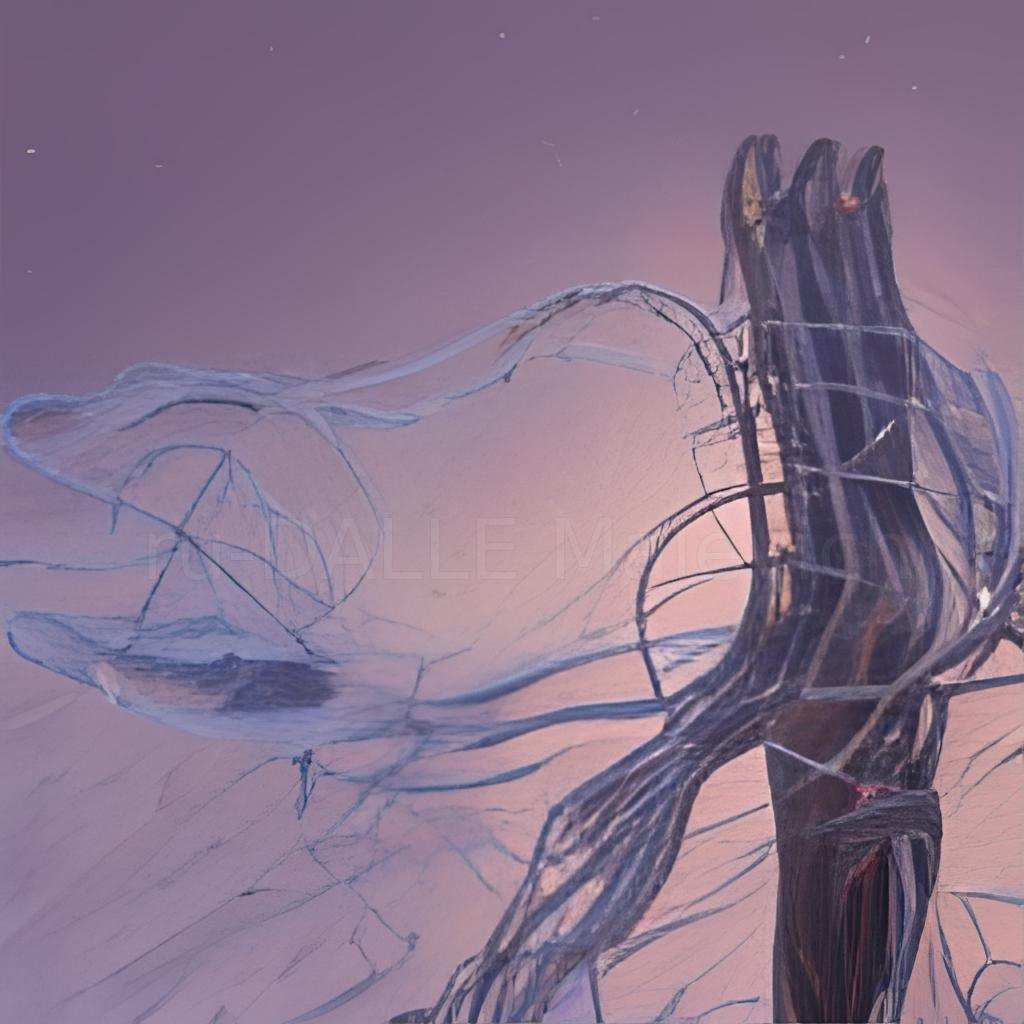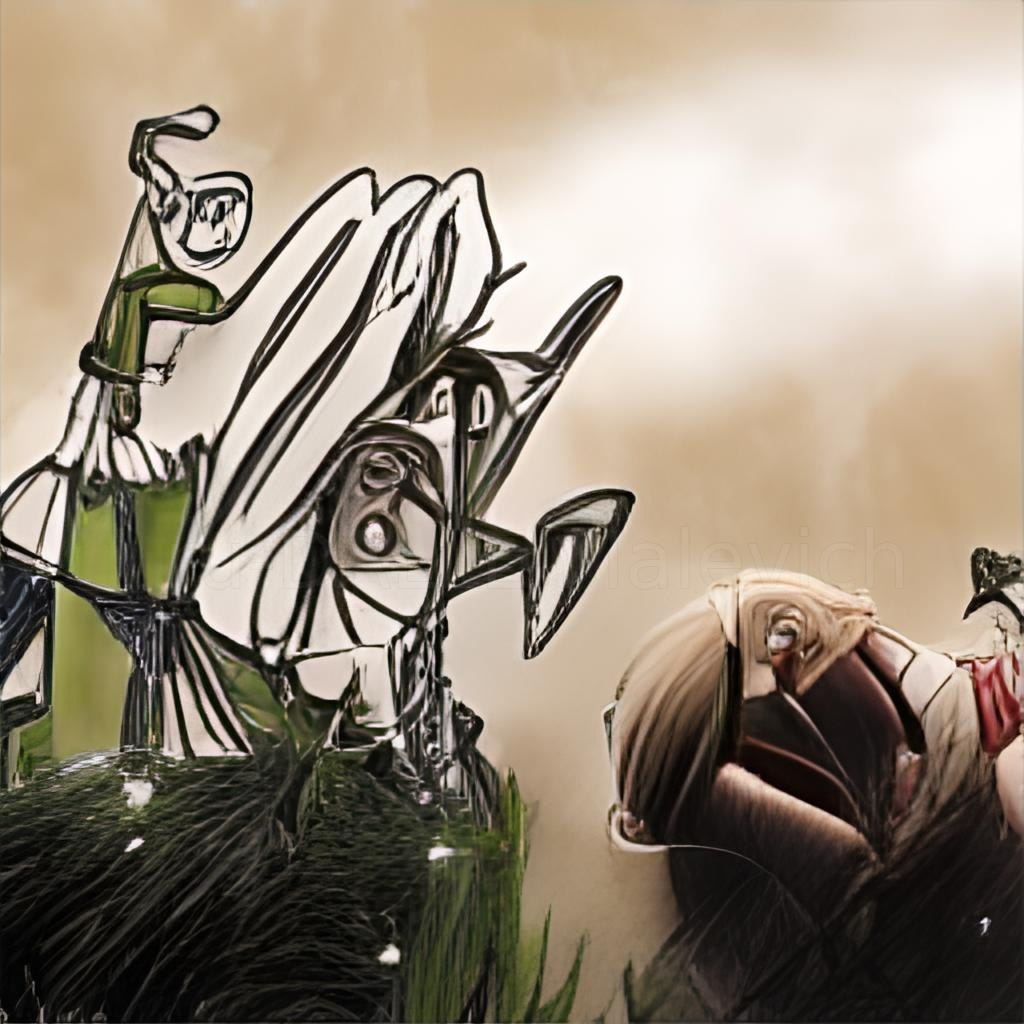

"влияние функции активации на скорость обучения"

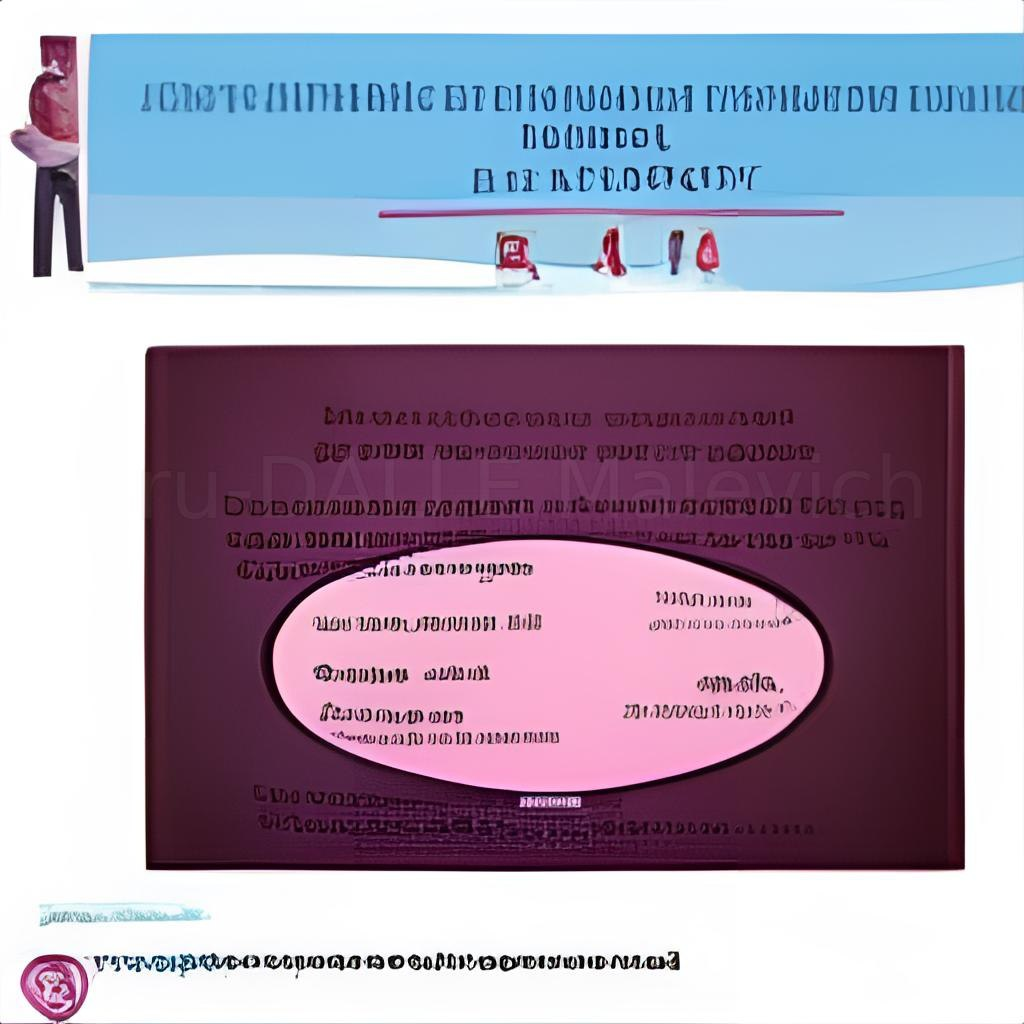